Deep Graph Library (DGL)

In [28]:
!pip install dgl

In [29]:
!pip install networkx

In [0]:
import dgl
import networkx as nx
import torch

##**NOTE**: This notebook was developed taking into account you read my article [Can Graph Neural Networks Solve Real-World Problems ](https://hackernoon.com/can-graph-neural-networks-solve-real-world-problems-7hd636dn) or have some previous domain knowledge. If you don't know about GNNs please take a minute and read my article, it will help you get a better understanding.

![alt text](https://media.giphy.com/media/WoWm8YzFQJg5i/giphy.gif)

# DONE READING? NOW, HAVE FUN!!!

# Node classification(Cluster formation)
Here we will binary node classification to predict whether a node is going to be in the cluster 1 or cluster 2 represented by node 0 and 33 which.
A typical example of friend recommendation system, just like facebook does to you. 

Credits for the dataset and example to DGL(Deep Graph Library) library [website](https://docs.dgl.ai/tutorials/basics/1_first.html).

![alt text](http://snap.stanford.edu/gnnexplainer/files/explainer-introduction.jpg)
*Image credits to: http://snap.stanford.edu/gnnexplainer/*



**Libraries**:
 

*   **DGL** (Graph NN library built atop Pytorch endoresed by the inventor of GNNs himself Thomas Kipf)
*  **Networkx** (Python library for studying graphs and networks)
*   **Pytorch** (Most famous DL library)
*   **Matplotlib** (ploting library)
*   **pdb** (Python Debugger)





In [0]:
def build_graph():
    g = dgl.DGLGraph()
    g.add_nodes(34)
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src,dst)
    # edges are bidir
    g.add_edges(dst,src)
    return g



In [32]:
G=build_graph()
print('We have %d Nodes'% G.number_of_nodes())
print('We have %d edges'% G.number_of_edges())

We have 34 Nodes
We have 156 edges


In [0]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()

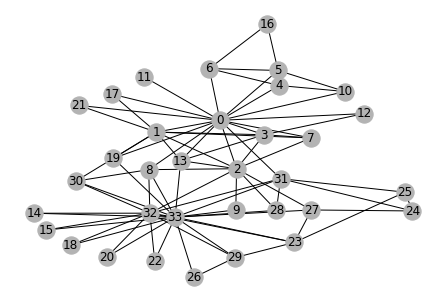

In [34]:
pos = nx.kamada_kawai_layout(nx_G) # style of the layout of the graph
nx.draw(nx_G, pos, with_labels =True, node_color=[[.7,.7,.7]])

## Step 2: Example of assigning features to nodes or edges
Graph neural networks associate features with nodes and edges for training. For our classification example, we assign each node an input feature as a one-hot vector: node vi‘s feature vector is [0,…,1,…,0], where the ith position is one.


In [0]:
G.ndata['features'] = torch.eye(34)

In [36]:
print(G.nodes[2].data['features'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [37]:
print(G.nodes[[10,11]].data['features'])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Step 3: Define a Graph Convolutional Network (GCN)
To perform node classification, use the Graph Convolutional Network (GCN) developed by Kipf and Welling. Here is the simplest definition of a GCN framework.

*   At layer l, each node V_li (where li = layer i) carries a feature vector H_li.
*   Each layer of the GCN tries to aggregate the features from U_li where U_i‘s are neighborhood nodes to V into the next layer representation at V_l+1i. 

This is followed by an affine transformation with some non-linearity.
The above definition of GCN fits into a message-passing paradigm: Each node will update its own feature with information sent from neighboring nodes. A graphical demonstration is displayed below.
![alt text](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png)

In [0]:
import torch.nn as nn
import torch.nn.functional as F



**Message passing**(MP): 
outlines a general framework of spatial-based ConvGNNs. It treats
graph convolutions as a message passing process in which
information(node features/datat) can be passed from one node to another along
edges directly. MP runs K-step message passing iterations
to let information propagate further, thus each node learns more about its sorrounding nodes(refered to as 1st-order neighbours), also learns about its 2nd-order neighbour and we can repeat the process until each node learns about its n-order neighbours.  <br>
![alt text](https://www.outsystems.com/blog/-/media/images/blog/posts/graph-neural-networks/nn-gif-5.gif?h=393&w=750)


**Reduce functions**(RF):  Each node has two members, data and mailbox. Data contains the node features and mailbox contains all incoming message features, stacked along the second dimension (hence the dim=1 argument). And RF takes the **`sum`** or **` mean `**of the incoming nods with the source node.

In [0]:
# Define message and reduce function
def gcn_message(edges):
    # The argument is a batch of edges
    # This computes a batch of message called 'msg' using the source node's feature 'h'
    return {'msg': edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox 
    return {'h': torch.sum(nodes.mailbox['msg'], dim=1)}

**Use higher-level APIs for efficiency** <br>
DGL provides many routines that combine basic send and recv in various ways. These routines are called level-2 APIs. For example: 


```
# def forward(self, g, inputs):
    ...
    g.update_all(message_func = gcn_message,
                     reduce_func= gcn_reduce)
    ...
```


In addition to update_all, you can use pull, push, and send_and_recv in this level-2 category. For more information, see [API reference](https://docs.dgl.ai/api/python/function.html).

In [0]:
# Define GCN Layer module
class GCNLayer(nn.Module):
    def __init__(self, in_fts, out_fts):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_fts, out_fts)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features(readout)
        h = g.ndata.pop('h')
        return self.linear(h)

In [0]:
# Define a 2-layer GCN
class GCN(nn.Module):
    def __init__(self, in_fts, hidden_sz, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_fts, hidden_sz)
        self.gcn2 = GCNLayer(hidden_sz, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h 

In [0]:
net = GCN(34, 5, 2) 

In [43]:
net

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=34, out_features=5, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=5, out_features=2, bias=True)
  )
)

## Step 4: Data preparation and initialization
We use one-hot vectors to initialize the node features. Since this is a semi-supervised setting, only the john (node 0) and the Mary (node 33) are assigned labels. The implementation is available as follow.

In [0]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0,33])
labels = torch.tensor([0,1])

## Step 5: Train then visualize
The training loop is exactly the same as other PyTorch models. We (1) create an optimizer, (2) feed the inputs to the model, (3) calculate the loss and (4) use autograd to optimize the model.

In [45]:
optimizer= torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    optimizer.zero_grad()
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, dim=1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch}', 'Loss: %.4f' % loss.item())

Epoch: 0 Loss: 0.5473
Epoch: 1 Loss: 0.4169
Epoch: 2 Loss: 0.3221
Epoch: 3 Loss: 0.2385
Epoch: 4 Loss: 0.1719
Epoch: 5 Loss: 0.1197
Epoch: 6 Loss: 0.0794
Epoch: 7 Loss: 0.0505
Epoch: 8 Loss: 0.0311
Epoch: 9 Loss: 0.0186
Epoch: 10 Loss: 0.0109
Epoch: 11 Loss: 0.0064
Epoch: 12 Loss: 0.0038
Epoch: 13 Loss: 0.0023
Epoch: 14 Loss: 0.0015
Epoch: 15 Loss: 0.0009
Epoch: 16 Loss: 0.0006
Epoch: 17 Loss: 0.0004
Epoch: 18 Loss: 0.0003
Epoch: 19 Loss: 0.0002
Epoch: 20 Loss: 0.0002
Epoch: 21 Loss: 0.0001
Epoch: 22 Loss: 0.0001
Epoch: 23 Loss: 0.0001
Epoch: 24 Loss: 0.0001
Epoch: 25 Loss: 0.0000
Epoch: 26 Loss: 0.0000
Epoch: 27 Loss: 0.0000
Epoch: 28 Loss: 0.0000
Epoch: 29 Loss: 0.0000


This is a rather toy example, so it does not even have a validation or test set. Instead, Since the model produces an output feature of **size 2 for each node**(either 0,1), we can visualize by plotting the output feature in a 2D space. The following code animates the training process from initial guess (where the nodes are not classified correctly at all) to the end (where the nodes are linearly separable).

In [46]:
all_logits[0][:5] # printing first 5 elements of the first batch of outputs 

tensor([[ 0.5477, -1.2010],
        [ 0.3507, -0.7473],
        [ 0.2328, -0.9138],
        [ 0.1458, -0.7448],
        [ 0.2942, -0.4891]])

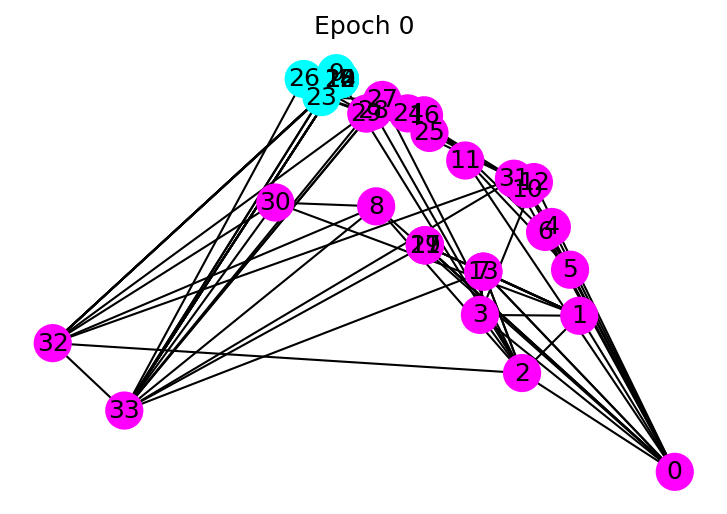

In [47]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34): # number of nodes
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, 
                     node_color=colors, node_size=300, ax = ax)
    
fig = plt.figure(dpi = 150)
fig.clf()
ax = fig.subplots()
draw(0)
plt.show()

In [48]:
ani = animation.FuncAnimation(fig, draw, frames = len(all_logits), interval=200)
rc('animation', html='jshtml')
ani
  

Output hidden; open in https://colab.research.google.com to view.

# Graph Classifiction

We will work on Mini Graph Classification Dataset that has 8 classes of different graphs. 
![alt text](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)
*Image credits: DGL Docs - > https://https://docs.dgl.ai/tutorials/basics/1_first.html*

As I refered in the article: [Can Graph Neural Networks Solve Real-World Problems ](https://https://hackernoon.com/can-graph-neural-networks-solve-real-world-problems-7hd636dn)
this example here is just a teaser to what we could do with Graph Neural Networks(GNNs).
We could easily train a graph classifier on a dataset of drugs vs protein to a relatevily good accuracy that can predict whether a molecular structure is a drug or not. 
I strongly believe this will catapult drug discovery to a whole new level since machines can hidden patterns within large amounts of data that us humans can't or simply would take us long to do.

**I'm working on a application of this technique on a real-world case scenario, it took me long but I finally found a website with graph datasets related to health. Stay tunned for that example.**

Credits of this tutorial to DGL [website](https://https://docs.dgl.ai/tutorials/basics/1_first.html).

In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt

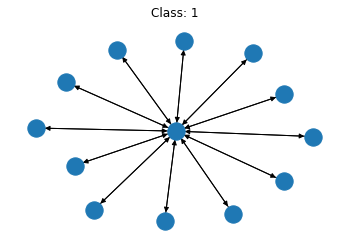

In [50]:
dataset = MiniGCDataset(80, 10, 20) # a tuple of (graph, label)
graph, label = dataset[10] # deconstruction assignment
fig, ax = plt.subplots() 
nx.draw(graph.to_networkx(), ax = ax) # network 
ax.set_title('Class: {:d}'.format(label))
plt.show()

##Batch samples
Batching graph inputs has two challenges:

*   Graphs are sparse.
*   Graphs can have various length. For example, number of nodes and edges.

To address this, DGL provides a `dgl.batch()` API. It leverages the idea that a batch of graphs can be viewed as a large graph that has many disjointed connected components(Adjancency of matrices). 

![alt text](https://1.bp.blogspot.com/-ip-AG9a8_zk/Ux5EUHIyB7I/AAAAAAAACLw/WM6wNqupeNk/s1600/Adjacency+Matrix+Representation+of+Undirected+Graph.JPG)

dgl.batch(graph1, graph2)


```
[(adjacency of graph1, 0),
(0, adjacency of graph2)]
```




In [0]:
def collate(samples):
    graph, labels = map(list, zip(*samples)) # arg:  func, iterable
    graph_batch = dgl.batch(graph)
    return graph_batch, torch.tensor(labels)

In [0]:
import dgl.function as fn
import torch.nn as nn
import pdb

**Graph classification process**
![alt text](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)
From a batch of graphs, perform message passing and graph convolution for nodes to communicate with others. After message passing, compute a tensor for graph representation from node (and edge) attributes. This step might be called readout or aggregation. Finally, the graph representations are fed into a classifier g to predict the graph labels.

**Graph convolution**

The graph convolution operation is basically the same as that for graph convolutional network (GCN). To learn more, see the GCN tutorial). The only difference is that we replace

 `h = ReLU(linear(torch.sum(nodes.mailbox['msg'], 1)))` by
 
  ` h =  RelU(linear(torch.mean(nodes.mailbox['msg'], 1)))`

The replacement of summation by average is to balance nodes with different degrees. This gives a better performance for this experiment.

The self edges added in the dataset initialization allows you to include the original node feature h(l)v when taking the average.

In [0]:
msg = fn.copy_u('h', 'm') # message passing

def reducer(nodes): 
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    def __init__(self, in_fts, out_fts, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_fts, out_fts)
        self.activation = activation
    
    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return{'h' : h}

class GCN(nn.Module):
    def __init__(self, in_fts, out_fts, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_fts, out_fts, activation)
    
    def forward(self, g, inputs):
        # Init node features
        g.ndata['h'] = inputs
        #pdb.set_trace() uncomment this line execute and see output line-by-line
        g.update_all(msg, reducer)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')


Consider initial node features to be **their degrees**. After 3 rounds of graph convolution, perform a graph readout by averaging over all node features for each graph in the batch and passing it to a fully connected layer.

In [0]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, activation=F.relu, n_extra_layers = 2):
        super(Classifier, self).__init__()
        self.gconv1 = GCN(in_dim, hidden_dim, activation)
        self.layers = nn.ModuleList([
            GCN(hidden_dim, hidden_dim, activation) for i in range(n_extra_layers)])
        self.ln = nn.Linear(hidden_dim, n_classes)

    def forward(self,g):
        # For undirected graphs, in_degree is the same as
        # out_degree
        h = g.in_degrees().view(-1, 1).float()
        # pdb.set_trace() uncomment this line execute and see output line-by-line
        h = self.gconv1(g, h)
        for gconv in self.layers:
            h = gconv(g, h)
        g.ndata['h'] = h # update node representations(data) for avg and readout
        hg = dgl.mean_nodes(g, 'h')
        return self.ln(hg) # classification

In [55]:
import torch.optim as optim
from torch.utils.data import DataLoader

# training & testing
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# We use the collate fn defined above with a Dataloader to create batches
data = DataLoader(trainset, 16, shuffle = True, collate_fn = collate)


# create model 
# in_fts = 1 because we passing a vector of nodes indegrees
# of size .view(-1, 1) since the graphs have different number 
# of nodes and edges and degres we can't fix the first dimension.
model = Classifier(1, 256, trainset.num_classes)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = 1e-2)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    acc = 0
    for i,(bg, label) in enumerate(data):
        opt.zero_grad()
        # pdb.set_trace()
        pred = model(bg)
        loss = loss_fn(pred, label)
        loss.backward()
        opt.step()
        epoch_loss+=loss.detach().item()
    epoch_loss /= (i+1)
    acc /= len(data) * 100
    print("Epoch: {}, Loss: {:.4f}".format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch: 0, Loss: 2.8453
Epoch: 1, Loss: 1.7920
Epoch: 2, Loss: 1.4413
Epoch: 3, Loss: 1.2986
Epoch: 4, Loss: 1.2462
Epoch: 5, Loss: 1.1451
Epoch: 6, Loss: 1.0528
Epoch: 7, Loss: 0.9451
Epoch: 8, Loss: 0.8046
Epoch: 9, Loss: 0.7909
Epoch: 10, Loss: 0.8586
Epoch: 11, Loss: 0.7999
Epoch: 12, Loss: 0.7287
Epoch: 13, Loss: 0.8004
Epoch: 14, Loss: 0.7471
Epoch: 15, Loss: 0.7485
Epoch: 16, Loss: 0.7200
Epoch: 17, Loss: 0.7486
Epoch: 18, Loss: 0.7243
Epoch: 19, Loss: 0.7022
Epoch: 20, Loss: 0.9102
Epoch: 21, Loss: 0.8474
Epoch: 22, Loss: 0.8523
Epoch: 23, Loss: 0.7214
Epoch: 24, Loss: 0.7069
Epoch: 25, Loss: 0.6476
Epoch: 26, Loss: 0.6588
Epoch: 27, Loss: 0.6650
Epoch: 28, Loss: 0.6312
Epoch: 29, Loss: 0.5991
Epoch: 30, Loss: 0.5844
Epoch: 31, Loss: 0.6057
Epoch: 32, Loss: 0.6169
Epoch: 33, Loss: 0.6086
Epoch: 34, Loss: 0.6291
Epoch: 35, Loss: 0.6282
Epoch: 36, Loss: 0.6235
Epoch: 37, Loss: 0.6800
Epoch: 38, Loss: 0.6233
Epoch: 39, Loss: 0.5988
Epoch: 40, Loss: 0.6128
Epoch: 41, Loss: 0.7808
Ep

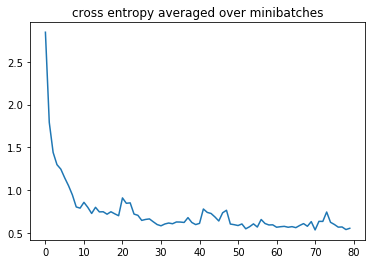

In [56]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Testing

In [57]:
model.eval()
all_preds = []
test_X, test_Y = collate(testset)
test_Y = test_Y.view(-1,1).float()
probs = torch.softmax(model(test_X), 1)
# The rows of input do not need to sum to one, 
# but must be non-negative, finite and have a non-zero sum.
sampled_Y = torch.multinomial(probs,1)
# Test accuracy using argmax
argmax_Y = torch.max(probs,1)[1].view(-1,1)
all_preds.append(argmax_Y)
print('Accuracy of sampled predictions on the testset: {:.4f}'.format(
    (sampled_Y == test_Y).sum().item() / len(testset) * 100))
print('Accuracy of argmax prediction on the testset: {:.4f}'.format(
    (argmax_Y == test_Y).sum().item() / len(testset) * 100))

Accuracy of sampled predictions on the testset: 61.2500
Accuracy of argmax prediction on the testset: 71.2500


## Visualizing results

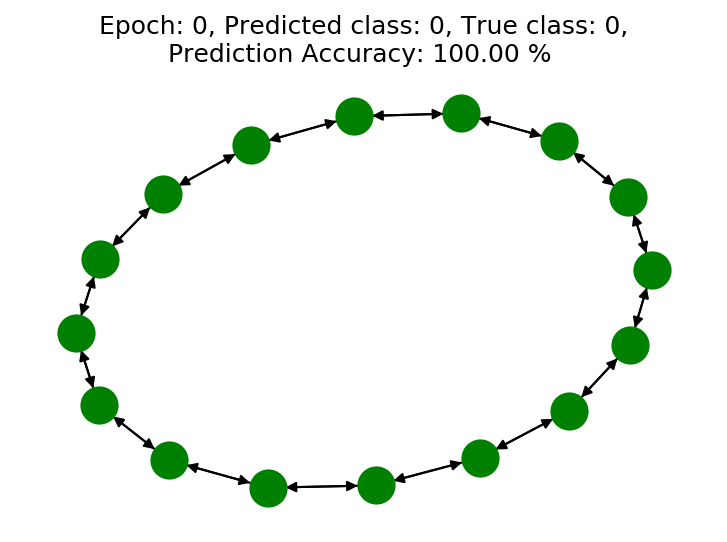

In [60]:
from matplotlib import animation, rc
def draw(i):
    clscolor1 = 'red'
    clscolor2 = 'green'
    colors = []
    colors.append(clscolor2 if (all_preds[0][i]==test_Y[i][0]) else clscolor1)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: {}, Predicted class: {}, True class: {},\nPrediction Accuracy: {:.2f} % '.format(i, all_preds[0][i].item(), int(test_Y[i][0]), torch.max(probs,1)[0][i]*100))
    nx.draw(testset[i][0].to_networkx(), 
                        node_color=colors, ax = ax)

fig = plt.figure(dpi = 150)
fig.clf()
ax = fig.subplots()
draw(0)
plt.show()

In [49]:
ani = animation.FuncAnimation(fig, draw, frames = len(probs), interval = 500)
rc('animation', html = 'jshtml')
ani

Output hidden; open in https://colab.research.google.com to view.

#Pytorch Geometric
Under Development....

In [0]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric

In [0]:
import torch
from torch_geometric.data import Data

In [0]:
edge_index  = torch.tensor([[0, 1, 1, 2],
                            [1, 0, 2, 1]], dtype= torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

In [0]:
data

In [0]:
print(data.keys)


In [0]:
print(data['x'])

In [0]:
data.num_nodes, data.num_edges, data.num_node_features

In [0]:
data.contains_isolated_nodes(), data.contains_self_loops(), data.is_directed()

In [0]:
# Transfer data object to GPU.
device = torch.device('cuda')
data = data.to(device)

Dataset

In [0]:
from torch_geometric.datasets import TUDataset

In [0]:
data = TUDataset(root='tmp/ENZYMES', name='ENZYMES')
data

In [0]:
data[0]